In [14]:
from hcipy import *
import hcipy
import numpy as np
import matplotlib.pyplot as plt

In [15]:
from IPython.display import Image
#Image('/Users/jfowler/iris_ao_specs.png')

In [16]:
#Image('/Users/jfowler/iris_ao_segments.png')
# keck has 36 segments, but doesn't have the central one
# check on ADS / SPIE for this kind of DM specs on segment size

In [17]:
# Keck segment size vs Iris AO segment size : 
iris_ao_diameter = .606*7
1.8/10.9, .7/iris_ao_diameter

(0.1651376146788991, 0.16501650165016502)

In [18]:
def make_keck_aperture(normalized=False, with_spiders=False, with_segment_gaps=False, gap_padding=0, segment_transmissions=1, return_header=False, return_segments=False):
    pupil_diameter = 10.9 #m actual circumscribed diameter
    actual_segment_flat_diameter = np.sqrt(3)/2 * 1.8 #m actual segment flat-to-flat diameter
    # iris_ao_segment = np.sqrt(3)/2 * .7 mm (~.606 mm) 
    actual_segment_gap = 0.003 #m actual gap size between segments
    # (3.5 - (3 D + 4 S)/6 = iris_ao segment gap (~7.4e-17) 
    spider_width = 1*0.02450 #m actual strut size
    gap_padding = 10.
    segment_gap = actual_segment_gap * gap_padding #padding out the segmentation gaps so they are visible and not sub-pixel
    segment_transmissions = 1.

    segment_flat_diameter = actual_segment_flat_diameter - (segment_gap - actual_segment_gap)
    segment_circum_diameter = 2 / np.sqrt(3) * segment_flat_diameter #segment circumscribed diameter

    num_rings = 3 #number of full rings of hexagons around central segment

    segment_positions = make_hexagonal_grid(actual_segment_flat_diameter + actual_segment_gap, num_rings)
    segment_positions = segment_positions.subset(lambda grid: ~(circular_aperture(segment_circum_diameter)(grid) > 0))

    segment = hexagonal_aperture(segment_circum_diameter, np.pi / 2)

    spider1 = make_spider_infinite([0, 0], 0, spider_width)
    spider2 = make_spider_infinite([0, 0], 60, spider_width)
    spider3 = make_spider_infinite([0, 0], 120, spider_width)
    spider4 = make_spider_infinite([0, 0], 180, spider_width)
    spider5 = make_spider_infinite([0, 0], 240, spider_width)
    spider6 = make_spider_infinite([0, 0], 300, spider_width)

    segmented_aperture = make_segmented_aperture(segment, segment_positions, segment_transmissions, return_segments=return_segments)
    
    def func(grid):
        res = segmented_aperture(grid) * spider1(grid) * spider2(grid) * spider3(grid)* spider4(grid) * spider3(grid)* spider5(grid) * spider6(grid) # * coro(grid)
        return Field(res, grid)
    
    return func

In [24]:
wavelength = 638e-9 # who knows if this is right?
keck_aperture = evaluate_supersampled(make_keck_aperture(), pupil_grid, 6)
wf = hcipy.Wavefront(keck_aperture, wavelength)
pupil_grid = make_pupil_grid(256, 1.5) # this might be totally wrong whoops
focal_grid = make_focal_grid(8, 12)  # same tho
prop = FraunhoferPropagator(pupil_grid, focal_grid)
img_ref = prop(wf).intensity

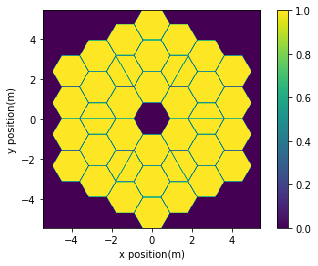

In [23]:
telescope_diameter = 10.9
num_pupil_pixels = 240 #based on PWFS sim 
# we should chose this based on image sampling
# make sure our sampling is fine enough to relate well to science plane
pupil_grid_diameter = telescope_diameter
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)

keck_aperture  =evaluate_supersampled(make_keck_aperture(telescope_diameter), pupil_grid, 6)

imshow_field(keck_aperture)
plt.xlabel('x position(m)')
plt.ylabel('y position(m)')
plt.colorbar()
plt.show()
# check the PDF -- for no segment gaps + zero intensity 

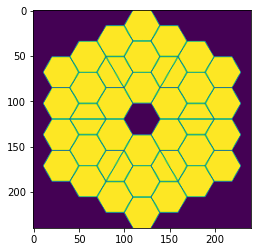

In [56]:
test = keck_aperture
plt.imshow(test.shaped)

from astropy.io import fits
hdu = fits.PrimaryHDU(test.shaped)
hdulist = fits.HDUList([hdu])
hdu.writeto('keck_aperture.fits', overwrite=True)

In [38]:
def make_iris_aperture(normalized=False, with_spiders=False, with_segment_gaps=False, gap_padding=0, segment_transmissions=1, return_header=False, return_segments=False):
    pupil_diameter = 1 #4.242 #mm actual circumscribed diameter, used for lam/D calculations other measurements normalized by this diameter
    actual_segment_flat_diameter = np.sqrt(3)/2 * .7 / 4 #mm actual segment flat-to-flat diameter
    actual_segment_gap = 0.001 #mm actual gap size between segments
    spider_width = 1*0.00850 #mm actual strut size
    gap_padding = 10.
    segment_gap = actual_segment_gap * gap_padding #padding out the segmentation gaps so they are visible and not sub-pixel
    segment_transmissions = 1.

    segment_flat_diameter = actual_segment_flat_diameter - (segment_gap - actual_segment_gap)
    segment_circum_diameter = 2 / np.sqrt(3) * segment_flat_diameter #segment circumscribed diameter

    num_rings = 3 #number of full rings of hexagons around central segment

    segment_positions = make_hexagonal_grid(actual_segment_flat_diameter + actual_segment_gap, num_rings)
    segment_positions = segment_positions.subset(lambda grid: ~(circular_aperture(segment_circum_diameter)(grid) > 0))

    segment = hexagonal_aperture(segment_circum_diameter, np.pi / 2)

    spider1 = make_spider_infinite([0, 0], 0, spider_width) # origin, degree, width 
    spider2 = make_spider_infinite([0, 0], 60, spider_width) 
    spider3 = make_spider_infinite([0, 0], 120, spider_width)
    spider4 = make_spider_infinite([0, 0], 180, spider_width)
    spider5 = make_spider_infinite([0, 0], 240, spider_width)
    spider6 = make_spider_infinite([0, 0], 300, spider_width)

    segmented_aperture = make_segmented_aperture(segment, segment_positions, segment_transmissions, return_segments=return_segments)
    
    def func(grid):
        res = segmented_aperture(grid) * spider1(grid) * spider2(grid) * spider3(grid)* spider4(grid) * spider3(grid)* spider5(grid) * spider6(grid) # * coro(grid)
        return Field(res, grid)
    
    return func

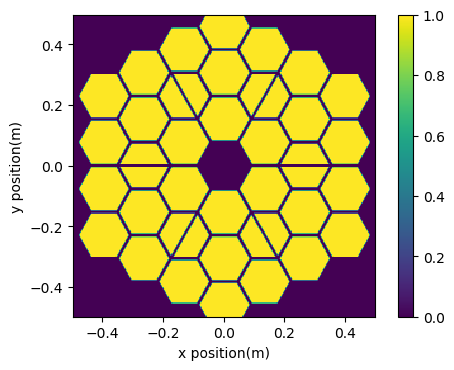

In [39]:
telescope_diameter = 1 #4.242
num_pupil_pixels = 240 #??
pupil_grid_diameter = telescope_diameter
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)

iris_aperture  =evaluate_supersampled(make_iris_aperture(telescope_diameter), pupil_grid, 6)

imshow_field(iris_aperture)
plt.xlabel('x position(m)')
plt.ylabel('y position(m)')
plt.colorbar()
plt.show()
#plt.savefig('test.png')

In [39]:
aperture = evaluate_supersampled(circular_aperture(1), pupil_grid, 4)
lyot_mask = evaluate_supersampled(circular_aperture(0.95), pupil_grid, 4)

In [ ]:
plt.subplot(1,2,1)
plt.title('Aperture')
imshow_field(aperture, cmap='gray')
plt.subplot(1,2,2)
plt.title('Lyot stop')
imshow_field(lyot_mask, cmap='gray')
plt.show()

In [ ]:
wf = Wavefront(aperture)
img_ref = prop(wf).intensity

imshow_field(np.log10(img_ref / img_ref.max()), vmin=-5, cmap='inferno')
plt.show()

In [ ]:
#LyotCoronagraph(pupil_grid, 1j*np.ones_like(pupil_grid))

In [ ]:
charge = 2
coro = VortexCoronagraph(pupil_grid, charge)
lyot_stop = Apodizer(lyot_mask)

In [ ]:
lyot = coro(wf)
imshow_field(lyot.intensity)
plt.show()

Questions
---------
1. It looks like segment geometry may *not* be the same? Should we be worried?
   a. Am I right about what I'm comparing as far as segment diameter vs flat diameter vs aperture? 
   b. Have I introduced any artifacts when I made a comparison plot? I think the only thing I played fast and loose with is segment gap and spider width. 
2. I'm having trouble getting a good estimate for segment gap on the Iris AO. Maybe this isn't a problem bc we pad it anyway?
3. Why aren't he gaps entirely blacked out? I expect this from other plotting. Does it make a difference? 
4. Is pixel size w/r/t science camera or WFS? Does it matter? 
5. Thinking next I should try to use HCIPy to simulate a basic version of our Lyot Stop + our FPM. Am I on the right track? 

What are the comparable segment gaps? 
Can we scoop up the Iris AO python control code??


In [ ]:
# IWA vs contrast curve 
# ex 3 lam/D size FPM (wv is 633 nm)
# make sure this is a *feasible* design with the vendor 

# tests of the spatial light interferometer -- speed and position
# use speedy SH to see if we're actually moving quickly
# up to 6pi phase offset, but it will be slower...
# mirror size / r0 of Keck is only BARELY 6pi

In [3]:
from hcipy import *
import numpy as np
import matplotlib as mpl
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import animation
from IPython.display import HTML

In [302]:
num_airy = 20 # WHO IS SHE? 
sampling = 6
norm = False

actual_segment_flat_diameter = np.sqrt(3)/2 * 1.8 #m actual segment flat-to-flat diameter
telescope_diameter = actual_segment_flat_diameter * 7
num_pupil_pixels = 1080 #based on PWFS sim 
# we should chose this based on image sampling
# make sure our sampling is fine enough to relate well to science plane
pupil_grid_diameter = telescope_diameter

pupil_grid = hcipy.make_pupil_grid(dims=num_pix, diameter=pupil_grid_diameter)
focal_grid = hcipy.make_uniform_grid([2*num_airy*sampling]*2, 2*num_airy * wavelength / pupil_grid_diameter)
prop = hcipy.FraunhoferPropagator(pupil_grid, focal_grid)

In [293]:
mpl.rcParams['figure.dpi'] = 100

#pupil_grid = make_pupil_grid(256, 1.5)
#focal_grid = make_focal_grid(8, 12)
#prop = FraunhoferPropagator(pupil_grid, focal_grid)


wavelength = 638e-9 # who knows if this is right?
wf = hcipy.Wavefront(iris_aperture, wavelength)

prop = FraunhoferPropagator(pupil_grid, focal_grid)
img_ref = prop(wf).intensity

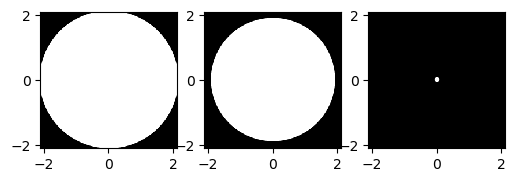

In [525]:
telescope_diameter = 4.242
num_pupil_pixels = 240 #??

# or do them segments need some aligning?
pupil_grid_a = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)
focal_grid_a = make_focal_grid(8, 12)

prop_a = FraunhoferPropagator(pupil_grid_a, focal_grid_a)

iris_aperture_a = evaluate_supersampled(make_iris_aperture(telescope_diameter), pupil_grid_a, 6)
iris_aperture_a = evaluate_supersampled(circular_aperture(telescope_diameter), pupil_grid_a, 6)
lyot_mask_a = evaluate_supersampled(circular_aperture(3.8), pupil_grid_a, 6)
fpm_a = evaluate_supersampled(circular_aperture(.15), pupil_grid_a, 6)
# circular aperture will vary
plt.subplot(1, 3, 1)
imshow_field(aperture, cmap='gray')
plt.subplot(1, 3, 2)
imshow_field(lyot_mask_a, cmap='gray')
plt.subplot(1, 3, 3)
imshow_field(fpm_a, cmap='gray')
plt.show()

# invert fpm ???
# transmissive FPM 

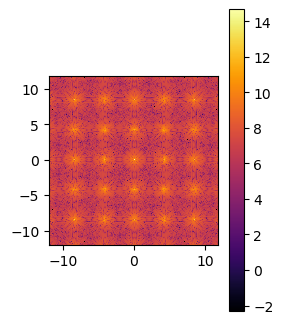

In [534]:
wavelength = 638e-9 # who knows if this is right?

wf = hcipy.Wavefront(iris_aperture_a, wavelength)
img_ref_a = prop_a(wf).intensity

#imshow_field(img_ref, cmap='inferno')

plt.subplot(1, 2, 1)
imshow_field(np.log10(img_ref_a), cmap='inferno')
#plt.colorbar()
plt.colorbar()
#plt.subplot(1, 2, 2)
#ref_phase_a = prop_a(wf).phase
#imshow_field(ref_phase_a)
#plt.colorbar()
plt.show()

#imshow_field(np.log10(img_ref / img_ref.max()), vmin=-5, cmap='inferno')
#plt.show()

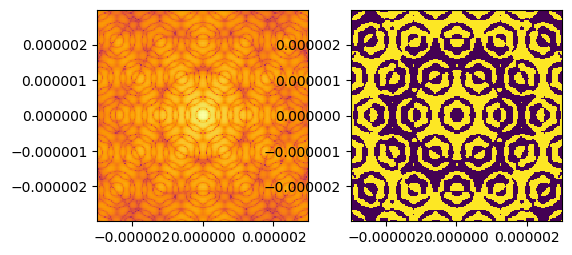

In [401]:
num_airy = 20 # WHO IS SHE? 
sampling = 4
norm = False


#telescope_diameter = .04242
num_pupil_pixels = 240 #based on PWFS sim 
# we should chose this based on image sampling
# make sure our sampling is fine enough to relate well to science plane
pupil_grid_diameter = 4.242

actual_segment_flat_diameter = np.sqrt(3)/2 * 1.8 #m actual segment flat-to-flat diameter
focal_grid_diam_val = actual_segment_flat_diameter * 7

pupil_grid_b = hcipy.make_pupil_grid(dims=num_pix, diameter=pupil_grid_diameter)
focal_grid_b = hcipy.make_uniform_grid([2*num_airy*sampling]*2, 2*num_airy * wavelength / pupil_grid_diameter)
prop_b = FraunhoferPropagator(pupil_grid_b, focal_grid_b)
img_ref_b = prop_b(wf).intensity

iris_aperture_b = evaluate_supersampled(make_iris_aperture(telescope_diameter), pupil_grid_b, 4)
lyot_mask_b = evaluate_supersampled(circular_aperture(3.9), pupil_grid_b, 4)

# circular aperture will vary
plt.subplot(1, 2, 1)
imshow_field(np.log10(img_ref_b / img_ref_b.max()),vmin=-20, cmap='inferno')
#plt.colorbar()
plt.subplot(1, 2, 2)
ref_phase = prop_b(wf).phase
imshow_field(ref_phase)
plt.show()


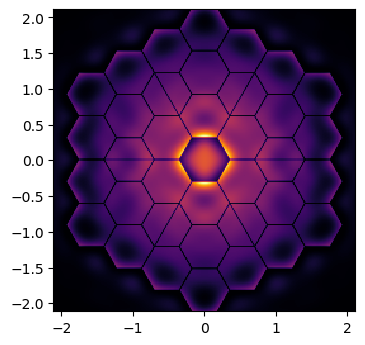

In [482]:
charge = 2
coro_a = VortexCoronagraph(pupil_grid_a, charge)
l_coro_a = LyotCoronagraph(pupil_grid_a, fpm_a)
lyot_stop_a = Apodizer(lyot_mask_a)
lyot_stop_b = Apodizer(lyot_mask_b)

wf_a = Wavefront(iris_aperture_a)
lyot_plane_a = l_coro_a(wf_a)

imshow_field(lyot_plane_a.intensity, vmin=0, cmap='inferno')
plt.show()

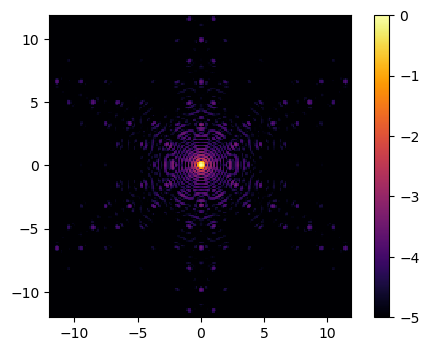

In [483]:
post_lyot_mask_a = lyot_stop_a(lyot_plane_a)
img_a = prop_a(post_lyot_mask_a).intensity

#imshow_field(np.log10(img / img_ref.max()), cmap='inferno')
imshow_field(np.log10(img_a/img_a.max()), vmin=-5, cmap='inferno')
plt.colorbar()

plt.show()

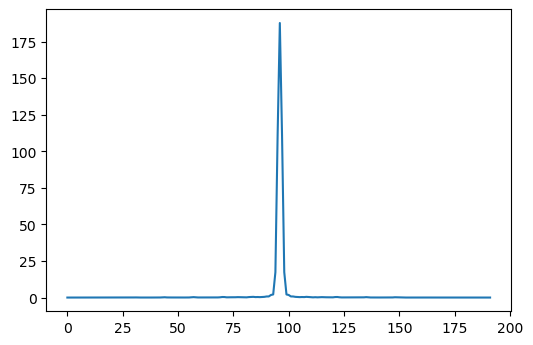

In [484]:
intensity_data = img_a.shaped
dz = intensity_data[75:120, 75:120]
#plt.imshow(np.log10(dz/np.max(dz)))
#plt.show()
sums = np.sum(intensity_data, axis=1)

plt.plot(np.arange(len(sums)), sums)
plt.show()

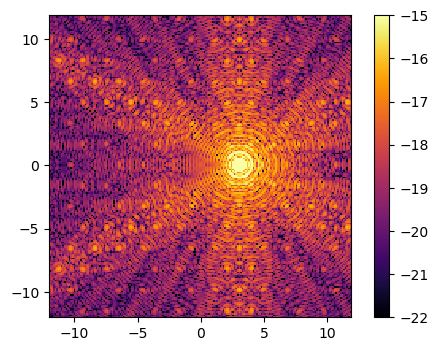

In [420]:
wf_a = Wavefront(iris_aperture_a * np.exp(4j * np.pi * pupil_grid_a.x * 1.5))
wf_b = Wavefront(iris_aperture_b * np.exp(2j * np.pi * pupil_grid_b.x * 1.5))
img_a = prop_a(lyot_stop_a(l_coro_a(wf_a))).intensity
img_b = prop_b(lyot_stop_b(coro_b(wf_b))).intensity


#imshow_field(np.log10(img / img_ref.max()), cmap='inferno')
imshow_field(np.log10(img_a/img_ref_a.max()), vmin=-22, vmax=-15, cmap='inferno')
plt.colorbar()

plt.show()

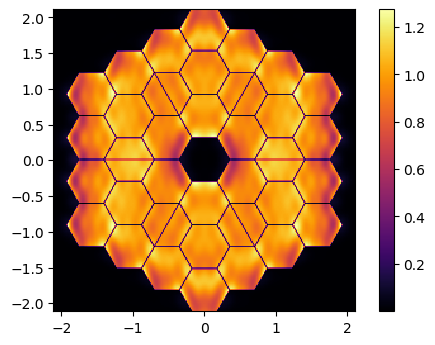

In [412]:
lyot_a = l_coro_a(wf_a)
lyot_b = coro_b(wf_b)

imshow_field(lyot_a.intensity, cmap='inferno')
plt.colorbar()
plt.show()

In [431]:
hcipy.Field?

In [495]:
def sloppy_spit_out_intensity(fpm_diameter, lyot_diameter):
    telescope_diameter = 4.242
    num_pupil_pixels = 240 #??

    # or do them segments need some aligning?
    pupil_grid_a = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)
    focal_grid_a = make_focal_grid(8, 12)

    prop_a = FraunhoferPropagator(pupil_grid_a, focal_grid_a)

    iris_aperture_a = evaluate_supersampled(make_iris_aperture(telescope_diameter), pupil_grid_a, 6)
    lyot_mask_a = evaluate_supersampled(circular_aperture(lyot_diameter), pupil_grid_a, 6)
    fpm_a = evaluate_supersampled(circular_aperture(fpm_diameter), pupil_grid_a, 6)
    
    wavelength = 638e-9 # who knows if this is right?

    wf = hcipy.Wavefront(iris_aperture_a, wavelength)
    img_ref_a = prop_a(wf).intensity
    
    coro_a = VortexCoronagraph(pupil_grid_a, charge)
    l_coro_a = LyotCoronagraph(pupil_grid_a, fpm_a)
    
    wf_a = Wavefront(iris_aperture_a)
    lyot_plane_a = l_coro_a(wf_a)
    
    post_lyot_mask_a = lyot_stop_a(lyot_plane_a)
    img_a = prop_a(post_lyot_mask_a).intensity
    
    intensity_data = img_a.shaped

    return intensity_data
    

0.04 0.350186237795432


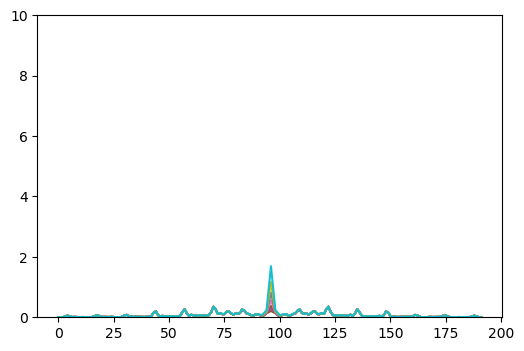

In [515]:
lowest = 10
d = 0
lyot_diameter = 3.8
fpm_diameter = np.arange(0, .1, .01)
for fpm_d in fpm_diameter:
    intensity_curve = np.sum(sloppy_spit_out_intensity(fpm_d, lyot_diameter), axis=1)
    if np.max(intensity_curve) < lowest:
        lowest = np.max(intensity_curve)
        d = fpm_d
        
    plt.plot(np.arange(len(intensity_curve)), intensity_curve)
print(d, lowest)
plt.ylim(0,10)
plt.show()

0 0.3


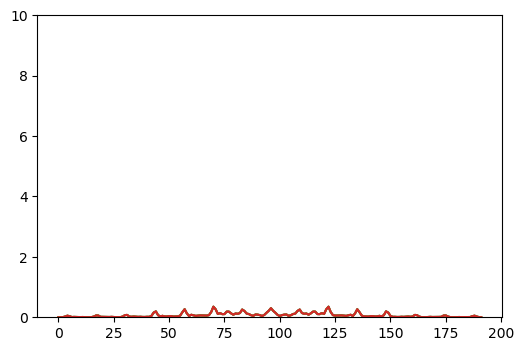

In [518]:
lowest = .3
d = 0
lyot_diameter = np.arange(3.5, 4.5, .25)
fpm_diameter = .04
for lyot_d in lyot_diameter:
    intensity_curve = np.sum(sloppy_spit_out_intensity(fpm_diameter, lyot_d), axis=1)
    if np.max(intensity_curve) < lowest:
        lowest = np.max(intensity_curve)
        d = lyot_d
        
    plt.plot(np.arange(len(intensity_curve)), intensity_curve)
print(d, lowest)
plt.ylim(0,10)
plt.show()

In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import hcipy
from hcipy import *


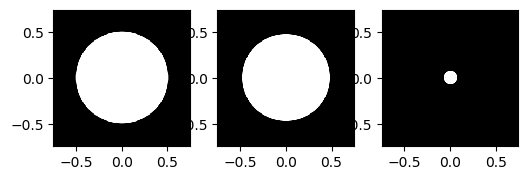

In [34]:
mpl.rcParams['figure.dpi'] = 100

telescope_diameter = 4.242
num_pupil_pixels = 240 #??
pupil_grid_diameter = telescope_diameter

# or do them segments need some aligning?
pupil_grid = make_pupil_grid(256, 1.5)
focal_grid = make_focal_grid(8, 12)

prop = FraunhoferPropagator(pupil_grid_a, focal_grid_a)
#test_aperture = evaluate_supersampled(circular_aperture(telescope_diameter), pupil_grid_a, 6)
#test_aperture = evaluate_supersampled(circular_aperture(1), pupil_grid_a, 6)
#lyot_mask_a = evaluate_supersampled(circular_aperture(3.8), pupil_grid_a, 6)
#lyot_mask = evaluate_supersampled(circular_aperture(.95), pupil_grid_a, 6)
fpm_a = evaluate_supersampled(circular_aperture(.15), pupil_grid_a, 6)

aperture = evaluate_supersampled(circular_aperture(1), pupil_grid, 4)
lyot_mask = evaluate_supersampled(circular_aperture(0.95), pupil_grid, 4)

# circular aperture will vary
plt.subplot(1, 3, 1)
imshow_field(test_aperture, cmap='gray')
plt.subplot(1, 3, 2)
imshow_field(lyot_mask, cmap='gray')
plt.subplot(1, 3, 3)
imshow_field(fpm_a, cmap='gray')
plt.show()

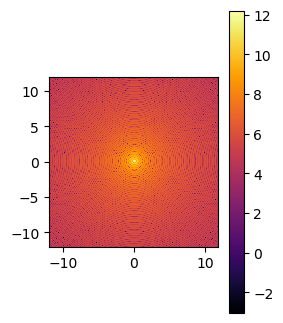

In [35]:
wavelength = 638e-9 # who knows if this is right?

wf = hcipy.Wavefront(aperture, wavelength)
img_ref_a = prop(wf).intensity


plt.subplot(1, 2, 1)
imshow_field(np.log10(img_ref_a), cmap='inferno')
plt.colorbar()
plt.show()



In [18]:
12/1.5 * telescope_diameter

33.936